# The lorenz systeme
## introduction
The Lorenz system is a mathematical model that illustrates how dynamic systems can exhibit chaotic behavior. It was introduced by Edward Lorenz in 1963, primarily to model atmospheric convection.
## The equations
The Lorenz system is a set of three coupled, nonlinear differential equations:

\begin{cases}
\frac{dx}{dt} = \sigma (y - x) \\
\frac{dy}{dt} = x (\rho - z) - y \\
\frac{dz}{dt} = xy - \beta z
\end{cases}

where:
*   x, y and z represent the system state,
*   σ, ρ and β are parameters that influence the system's behavior.

Typically, the parameters are set to:

* σ=10
* ρ=28
* β = $\frac{8}{3}$

# Solvers

## Explicit Euler
The explicit Euler method is a simple and commonly used technique for solving ordinary differential equations (ODEs). It approximates the solution of an ODE by advancing in small increments from a known initial condition.

Consider a first-order ODE of the form:
$$
\frac{dy}{dt} = f(t, y), \quad y(t_0) = y_0,
$$

The forward Euler method uses the following iterative formula to advance the solution from $t_n$ to $t_{n+1}$:

$$
y_{n+1} = y_n + h \cdot f(t_n, y_n).
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal
from filterpy.kalman import EnsembleKalmanFilter as EnKF
from filterpy.common import Q_discrete_white_noise

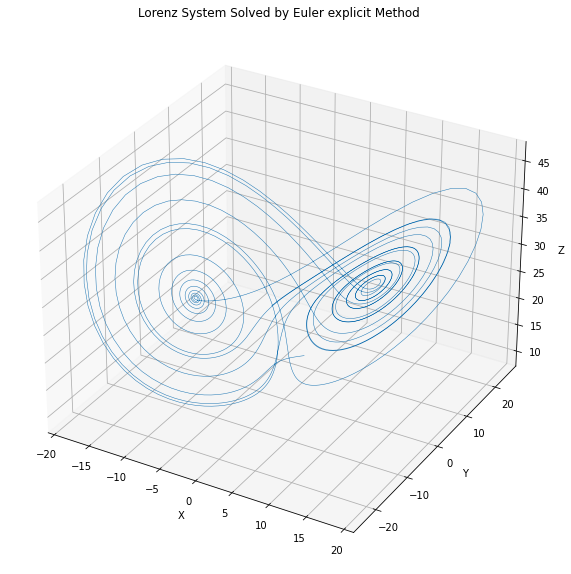

In [3]:
# Définir les paramètres du système de Lorenz
sigma, rho, beta = 10, 28, 8/3

# Définir la fonction du système de Lorenz
def lorenz(state, dt):
    x, y, z = state
    return np.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])

# Méthode d'Euler explicite pour résoudre le système de Lorenz
def euler(odefun, tspan, y0, Nh):
    h = (tspan[1] - tspan[0]) / Nh  # Taille de chaque intervalle
    t = np.linspace(tspan[0], tspan[1], Nh + 1)  # Points de temps
    u = np.zeros((Nh + 1, len(y0)))  # Initialisation du tableau de solutions
    u[0, :] = y0  # Définir la condition initiale

    for i in range(Nh):
        u[i + 1, :] = u[i, :] + h * odefun(u[i, :], h)

    return t, u

# Initialiser les conditions initiales et les paramètres de l'intégration
u0 = np.array([5., -5., 20.])
tspan = np.array([0., 20.])
Nh = 1800

# Résoudre le système de Lorenz
t, true_trajectory = euler(lorenz, tspan, u0, Nh)

# Tracé des résultats en 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.plot(true_trajectory[:, 0], true_trajectory[:, 1], true_trajectory[:, 2], lw=0.5)
ax.set_title("Lorenz System Solved by Euler explicit Method")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

The 3D graph shows the complete trajectories of the Lorenz system in the state space $(x,y,z)$. This type of graph highlights the overall shape and chaotic patterns of the system's dynamics.

A double spiral structure can be observed, a characteristic of the solutions of the Lorenz system. The two spirals show that the trajectories can come close together and then diverge unpredictably, which is a fundamental property of chaotic systems.

## The Ensemble Kalman Filter

The Ensemble Kalman Filter (EnKF) is a state estimation method for nonlinear and stochastic systems, as well as high-dimensional problems.

The fundamental principle of the EnKF is based on propagating an ensemble of state samples through a dynamic model and updating these samples based on observations.

**Propagation through the Model**
Each member of the ensemble is independently propagated through the dynamic model to obtain a forecast of the future state.

**Update with Observations**
The forecasts are then adjusted based on the available observations to produce an updated state estimate.

## Steps of the EnKF Algorithm

1. ** Initialization:**  
   Generate an initial set of state samples $\{x_i^0 \}_{i=1}^N$, where $N$ is the number of samples. These samples are randomly drawn according to an assumed initial state distribution. Typically, they are generated by perturbing an initial estimate $x_0$ with a noise distribution, modeled by a multivariate normal distribution with a mean $x_0$ and an initial covariance matrix $P$.

2. **Prediction Step:**  
   For each member of the ensemble, propagate the state through the model to obtain the predicted state:

   $$x_i^{\text{pred}} = f(x_i^{\text{upd}}) + w_i$$

   where:
   - ${x}_i^{\text{upd}}$ is the analysis state of member $i$ from the previous step,
   - $f(x)$ is the state transition function that describes the system dynamics,
   - $w_i$  is a process noise vector drawn randomly, representing model uncertainties, often modeled as a Gaussian random variable with zero mean and covariance matrix $Q$.
   

3. **Update Step:**  
   The available observations are used to correct the forecasts and adjust the state samples. For each member of the ensemble, a simulated observation $z_i^{\text{pred}}$ is calculated using:
   $$z_i^{\text{pred}} = h(x_i^{\text{pred}}) + v_i$$
   where:
  
   - $h(x)$ is the observation function that relates the state to the measurements,
   - $v_i$  is a measurement noise vector drawn randomly, often modeled as a Gaussian random variable with zero mean and covariance matrix $R$.
 

   The forecasts are updated by calculating the Kalman gain, which is used to adjust the forecasts based on the observations:
   $$K_k = P_k^{\text{pred}} H^T (H P_k^{\text{pred}} H^T + R)^{-1}$$

   where $H$ is the Jacobian matrix of the observation function. The Kalman gain $K_k$ is then used to adjust the predicted states:
   $$ x_i^{\text{upd}} = x_i^{\text{pred}} + K_k (z_k - h(x_i^{\text{pred}}) + v_i)$$

   where $z_k$ is the observed measurement at time $k$.

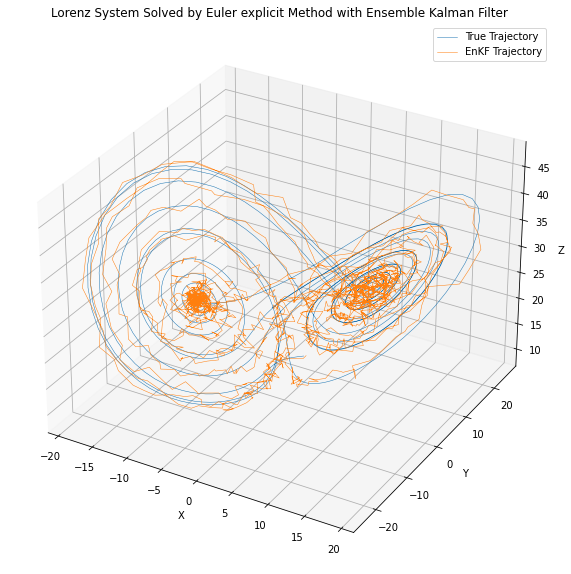

In [4]:
# Définir les paramètres du filtre de Kalman d'ensemble
N = 20  # Nombre d'ensembles
dim_x = 3  # Dimension de l'état
dim_z = 3  # Dimension de l'observation

# Matrices de covariance
Q = Q_discrete_white_noise(dim=dim_x, dt=1.0, var=0.01)  # Covariance de processus
R = np.eye(dim_z) * 1.0   # Covariance d'observation

# Initialiser l'ensemble
ensemble = np.zeros((N, dim_x))
for i in range(N):
    ensemble[i] = u0 + np.random.randn(dim_x)  # Initialiser les ensembles

# Définir les fonctions de transition d'état et de mesure
def hx(x):
    return x

def fx(x, dt):
    return x + dt * lorenz(x, dt)

initial_state = np.mean(ensemble, axis=0)

# Créer l'objet Ensemble Kalman Filter
enkf = EnKF(x=initial_state, P=Q, dim_z=dim_z, fx=fx, hx=hx, dt=0.01, N=N)

# Initialiser les ensembles dans l'objet Ensemble Kalman Filter
enkf.sigmas = ensemble

# Stocker les résultats
ensemble_trajectories = np.zeros((Nh + 1, dim_x))
ensemble_trajectories[0] = initial_state

# Filtre de Kalman d'ensemble
for i in range(1, Nh + 1):
    enkf.predict()
    z = true_trajectory[i] + multivariate_normal([0, 0, 0], R)
    enkf.update(z)
    ensemble_trajectories[i] = np.mean(enkf.sigmas, axis=0)

# Tracé des résultats en 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.plot(true_trajectory[:, 0], true_trajectory[:, 1], true_trajectory[:, 2], lw=0.5, label='True Trajectory')
ax.plot(ensemble_trajectories[:, 0], ensemble_trajectories[:, 1], ensemble_trajectories[:, 2], lw=0.5, label='EnKF Trajectory')
ax.set_title("Lorenz System Solved by Euler explicit Method with Ensemble Kalman Filter")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()

The EnKF allows tracking the chaotic behavior of the Lorenz system by incorporating noisy observations to correct its predictions. These corrections are visible as small oscillations around the true trajectory. This approach is essential for chaotic systems where uncertainties and estimation errors can quickly diverge. More specifically, the EnKF adjusts the state estimation based on the available observations. If these observations are noisy, the updates may lead to incorrect adjustments.

# Uncertainty

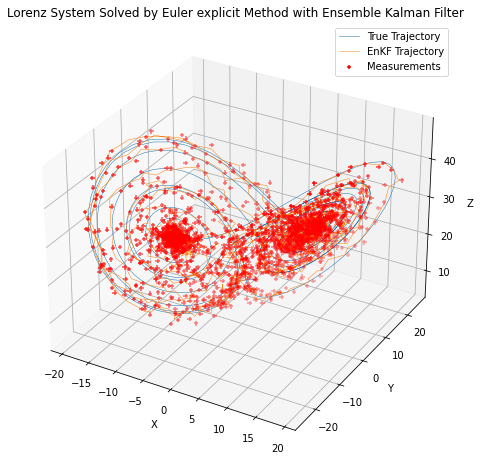

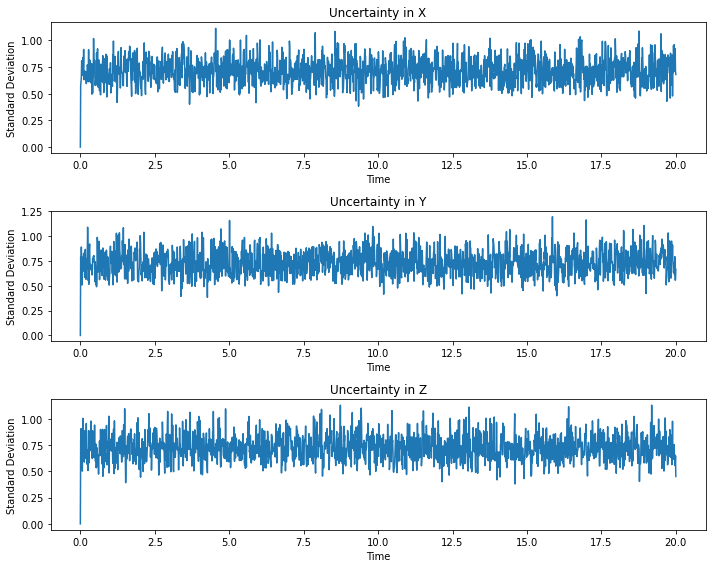

In [4]:
measurements = []
uncertainties = np.zeros((Nh + 1, dim_x))

# Filtre de Kalman d'ensemble
for i in range(1, Nh + 1):
    enkf.predict()  # Prédiction à chaque itération
    z = true_trajectory[i] + multivariate_normal([0, 0, 0], R)  # Observation avec bruit
    enkf.update(z)  # Mise à jour basée sur l'observation z
    ensemble_trajectories[i] = np.mean(enkf.sigmas, axis=0)  # Trajectoire estimée
    uncertainties[i] = np.std(enkf.sigmas, axis=0)  # Calculer l'écart-type (incertitude)
    measurements.append(z)


measurements = np.array(measurements)

# Tracé des résultats en 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

# Tracer la vraie trajectoire et la trajectoire estimée
ax.plot(true_trajectory[:, 0], true_trajectory[:, 1], true_trajectory[:, 2], lw=0.5, label='True Trajectory')
ax.plot(ensemble_trajectories[:, 0], ensemble_trajectories[:, 1], ensemble_trajectories[:, 2], lw=0.5, label='EnKF Trajectory')

# Tracer les mesures en tant que points '+'
ax.scatter(measurements[:, 0], measurements[:, 1], measurements[:, 2], marker='+', color='red', label='Measurements')

ax.set_title("Lorenz System Solved by Euler explicit Method with Ensemble Kalman Filter")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()

# Tracé des incertitudes
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

for i, label in enumerate(['X', 'Y', 'Z']):
    ax[i].plot(t, uncertainties[:, i])
    ax[i].set_title(f"Uncertainty in {label}")
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Standard Deviation")

plt.tight_layout()
plt.show()

The uncertainty graphs show fluctuations around 0.75 for all three dimensions (X, Y, Z).

These relatively low uncertainties mean that the dispersion of the ensemble around the mean is relatively small, indicating that the Ensemble Kalman Filter is quite confident in its predictions and maintains reasonable trust in its estimates, despite the chaotic behavior of the Lorenz system.


## 2. Individual Trajectories and Absolute Errors

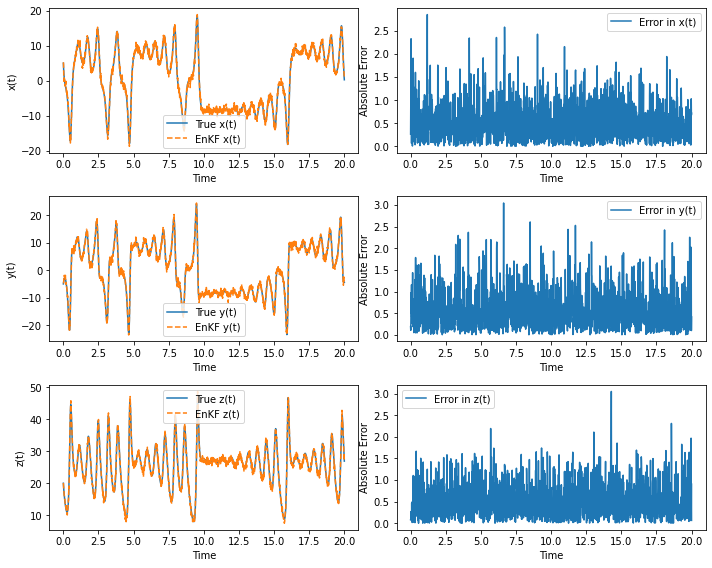

In [14]:
# Trajectoires individuelles et erreurs
fig, axs = plt.subplots(3, 2, figsize=(10, 8))

# Trajectoires individuelles
axs[0, 0].plot(t, true_trajectory[:, 0], label='True x(t)')
axs[0, 0].plot(t, ensemble_trajectories[:, 0], '--', label='EnKF x(t)')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('x(t)')
axs[0, 0].legend()

axs[1, 0].plot(t, true_trajectory[:, 1], label='True y(t)')
axs[1, 0].plot(t, ensemble_trajectories[:, 1], '--', label='EnKF y(t)')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('y(t)')
axs[1, 0].legend()

axs[2, 0].plot(t, true_trajectory[:, 2], label='True z(t)')
axs[2, 0].plot(t, ensemble_trajectories[:, 2], '--', label='EnKF z(t)')
axs[2, 0].set_xlabel('Time')
axs[2, 0].set_ylabel('z(t)')
axs[2, 0].legend()

# Erreurs absolues
axs[0, 1].plot(t, np.abs(true_trajectory[:, 0] - ensemble_trajectories[:, 0]), label='Error in x(t)')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Absolute Error')
axs[0, 1].legend()

axs[1, 1].plot(t, np.abs(true_trajectory[:, 1] - ensemble_trajectories[:, 1]), label='Error in y(t)')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Absolute Error')
axs[1, 1].legend()

axs[2, 1].plot(t, np.abs(true_trajectory[:, 2] - ensemble_trajectories[:, 2]), label='Error in z(t)')
axs[2, 1].set_xlabel('Time')
axs[2, 1].set_ylabel('Absolute Error')
axs[2, 1].legend()

plt.tight_layout()
plt.show()

## Individual Trajectories

**Observations**  
The three graphs on the left show the EnKF trajectories for the variables x(t), y(t), et z(t) compared to the true trajectories. It is observed that the estimated trajectories closely follow the true trajectories, with some deviations.

**Explanations**  
These graphs indicate that the EnKF is capable of tracking the Lorenz system dynamics, but there are occasional divergences. These small errors, though minimal, accumulate and become more visible in the 3D graph (the visible deviations in the 3D graph) due to the chaotic effect. Errors in one dimension can affect other dimensions and propagate, leading to noticeable global deviations.


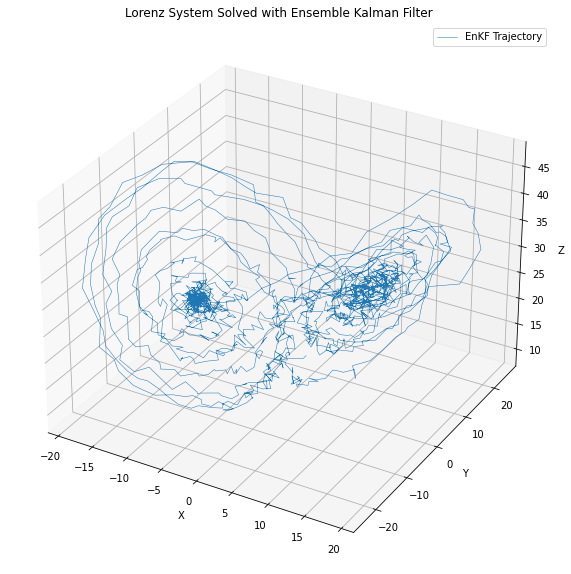

In [8]:
# Tracé des résultats en 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.plot(ensemble_trajectories[:, 0], ensemble_trajectories[:, 1], ensemble_trajectories[:, 2], lw=0.5, label='EnKF Trajectory')
ax.set_title("Lorenz System Solved with Ensemble Kalman Filter")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()

## Absolute Errors

The three graphs on the right show the absolute errors for the variables x(t), y(t), et z(t). It can be observed that the error varies but is often remains below 2, with some peaks reaching up to 3.

These errors demonstrate the moments when the EnKF struggles to precisely track the true trajectory. Despite these errors, they remain within a relatively small range (3). This suggests that the EnKF predictions are quite close to the true values, even in a chaotic system like the Lorenz system.

The observations used by the EnKF to update the system's estimated state are noisy, meaning they contain random errors. The filter attempts to correct its predictions based on the available observations. Each noisy observation results in a correction that may be slightly incorrect, creating oscillations.

As known, the Lorenz system is inherently chaotic. This means that small perturbations in initial conditions or updates can lead to significant differences in future trajectories. Even small errors introduced by noisy observations can propagate and amplify over time, leading to visible deviations between the true trajectory and the trajectory estimated by the EnKF.

# CONCLUSION

The Ensemble Kalman Filter (EnKF) is a powerful method for state estimation, but it is sensitive to errors in observations. In chaotic systems like the Lorenz system, these errors can lead to significant deviations from the true trajectory. These deviations are a direct consequence of updates based on noisy observations, which introduce errors into the state estimates.
